In [13]:
import models.unet as unet
import preproc.get_data as data
from metrics.visual import plot
import numpy as np
import sklearn
import os

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from skimage.io import imshow

In [3]:
model = unet.get_model(None,None,3)

In [4]:
x, y = data.get_training_data(rotate=True)
x_test, x_test_names = data.get_test_data()#resize=(400,400))

x_norm = x / 255.0
x_test_norm = x_test / 255.0

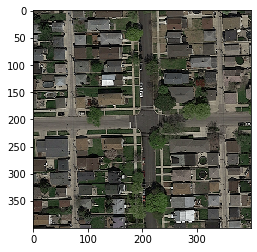

In [6]:
images = [x[0]]

plot(images)

In [7]:
USE_CLASS_WEIGHTS = True

class_weights = None
if USE_CLASS_WEIGHTS:
    flattened_y = []
    for a in y:
        flattened_y.extend(a.flatten())
    flattened_y = np.asarray(flattened_y)
    flattened_y.shape
    class_weights = sklearn.utils.class_weight.compute_class_weight('balanced',
                                                                    np.unique(flattened_y),
                                                                    flattened_y)
    #class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [8]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

    return 1 - numerator / denominator

In [16]:
#model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint('checkpoints/unet.h5', verbose=1, save_best_only=True)
history = model.fit(x_norm, y, validation_split=0.1, batch_size=8, epochs=100,
                    callbacks=[earlystopper, checkpointer], class_weight=class_weights)

Train on 360 samples, validate on 40 samples
Epoch 1/100
 64/360 [====>.........................] - ETA: 24s - loss: 0.6440 - accuracy: 0.6621WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

In [ ]:
pred = model.predict(x_norm[0:1])
im = (np.squeeze(pred) > 0.5).astype(np.uint8)

In [ ]:
imshow(im)

In [ ]:
pred

In [ ]:
pred = model.predict(x_norm[0:1])
plot([x_norm[0], y[0], pred.reshape(400, 400)])

In [ ]:
pred = model.predict(x_test_norm[0:1])
plot([x_test_norm[0], pred.reshape(608, 608)])

In [ ]:
pred = model.predict(x_test_norm[1:2])
plot([x_test_norm[1], pred.reshape(608, 608)])

In [ ]:
for i in range (x_test_norm.shape[0]):
    pred = (model.predict(x_test_norm[i:i+1]) > 0.5).astype(np.uint8)
    plot([x_test_norm[i], pred.reshape(608, 608)])

In [ ]:
for i in range (x_norm.shape[0]):
    pred = model.predict(x_norm[i:i+1])
    plot([x_norm[i], y[i], pred.reshape(400, 400)])

In [ ]:
np.argmax(pred, -1)

In [ ]:
x_test_norm.shape

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

for i in range (len(x_test_names)):
    name = x_test_names[i][18:]
    print(name)
    
    pred = model.predict(x_test_norm[i:i+1])
    pred = pred.reshape(608,608)
    pred = (pred > 0.5).astype(np.uint8)
    
    plt.imsave("output/"+name, pred, cmap=cm.gray)